# Module 9 Assignment 2: Financial Time Series - (Optional) Additional Points
Financial time series is an obvious area for the use of RNN, as the sequence is more important than the individual observations. By building models to forecast indices, you will learn how to employ them in time series modeling.

**Sachin Sharma**

**MSDS-422**

**08/14/2024**

## Management/Research Question
In layman’s terms, what is the management/research question of interest, and why would anyone care?

Requirements
1. Conduct your analysis using the specified 80 / 20 split.
2. Conduct EDA.
3. Build at least three RNN models based on hyperparameter tuning.
4. Evaluate goodness of fit metrics.
5. Discuss your model’s performance.

### Import Libraries

In [46]:
# Import necessary libraries for data analysis and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import plotly.express as px
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
from keras.optimizers import Adam
warnings.filterwarnings("ignore")

### EDA

In [3]:
# Read in data from a CSV file and store it in a pandas DataFrame
data = pd.read_csv("./input/Standard & Poor’s 500 index.csv")
if 'Unnamed: 0' in data.columns:
        data.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [4]:
data.shape

(1256, 7)

In [5]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-08-15,2846.199951,2856.669922,2825.510010,2847.600098,2847.600098,4041720000
1,2019-08-16,2864.739990,2893.629883,2864.739990,2888.679932,2888.679932,3524080000
2,2019-08-19,2913.479980,2931.000000,2913.479980,2923.649902,2923.649902,3221050000
3,2019-08-20,2919.010010,2923.629883,2899.600098,2900.510010,2900.510010,3067710000
4,2019-08-21,2922.040039,2928.729980,2917.909912,2924.429932,2924.429932,3016540000


In [ ]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
data['Date'] = pd.to_datetime(data['Date'])

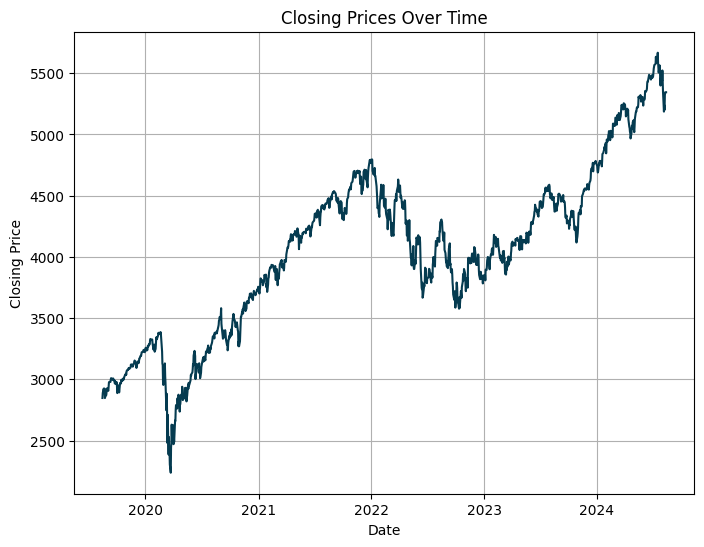

In [7]:
# Set the figure size for the plot
plt.figure(figsize=(8, 6))

# Plot the 'Close' prices over time
plt.plot(data['Date'], data['Close'], label='Close', color='#053B50')

# Set the plot title
plt.title('Closing Prices Over Time')

# Label the x-axis as 'Date'
plt.xlabel('Date')

# Label the y-axis as 'Closing Price'
plt.ylabel('Closing Price')
plt.grid(True)

In [8]:
fig = px.line(data, x="Date", y="Volume", title="Trading Volume Over Time")

# Customize the background color
fig.update_layout(plot_bgcolor='rgba(0, 0, 0, 0)')

# Customize the line color
fig.update_traces(line=dict(color="rgb(128, 0, 128)"))

# Set a wider figure size (adjust the width and height as needed)
fig.update_layout(width=800, height=400)

# Show the plot
fig.show()

Text(0, 0.5, 'Adj Close')

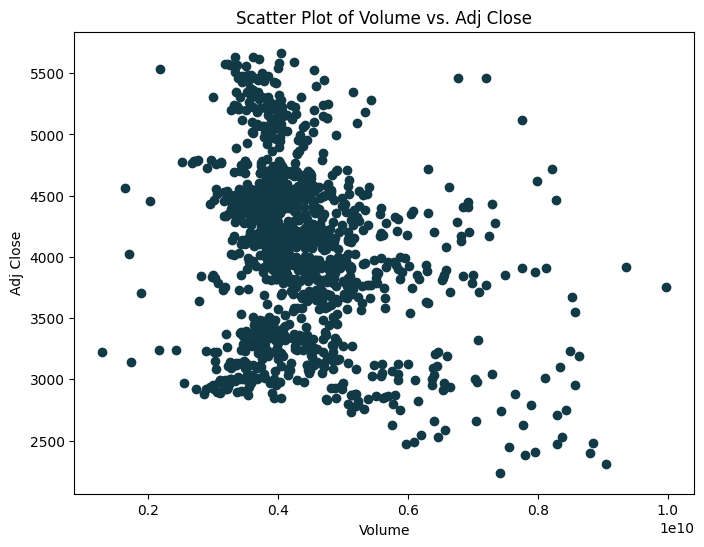

In [9]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(data['Volume'], data['Adj Close'], marker='o', color='#113946') # Set the figure size
plt.title('Scatter Plot of Volume vs. Adj Close') # Create a scatter plot of 'Volume' vs. 'Adj Close'
plt.xlabel('Volume') # Label for the x-axis
plt.ylabel('Adj Close') # Label for the y-axis

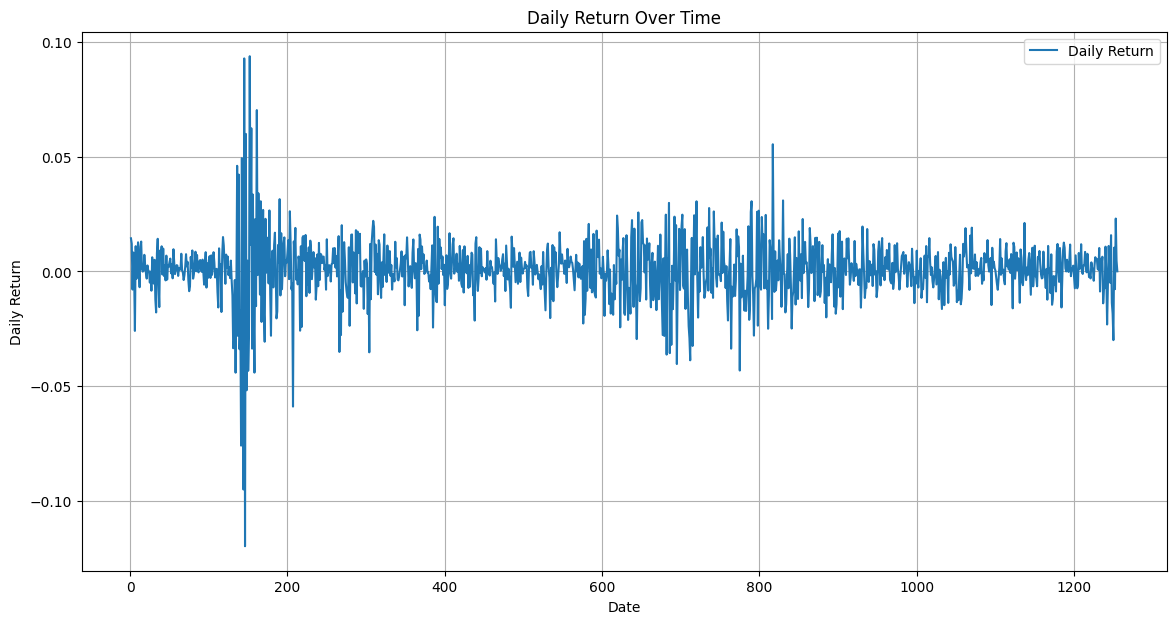

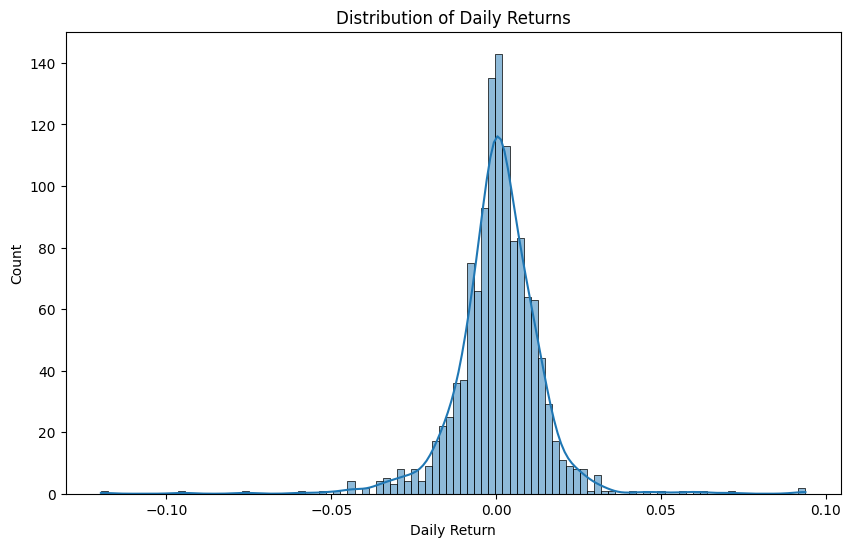

In [10]:
data["Daily Return"] = data["Close"].pct_change()
plt.figure(figsize=(14,7))
plt.plot(data["Daily Return"],label="Daily Return")
plt.title("Daily Return Over Time")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,6))
sns.histplot(data['Daily Return'].dropna(), bins=100, kde=True)
plt.title('Distribution of Daily Returns')
plt.show()

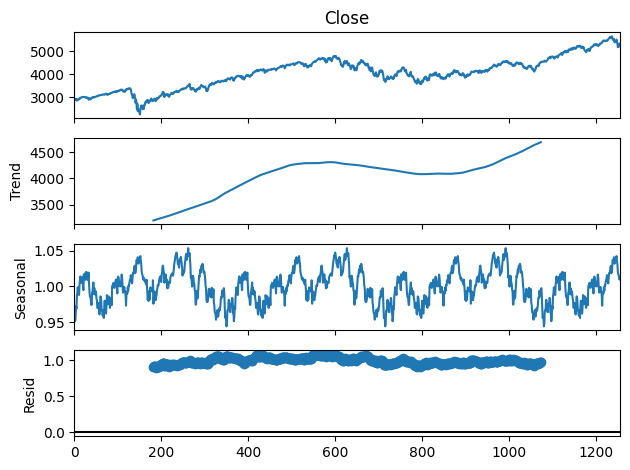

In [12]:
result = seasonal_decompose(data["Close"],model="multiplicative",period=365)
result.plot()
plt.show()

Text(0, 0.5, 'Volume')

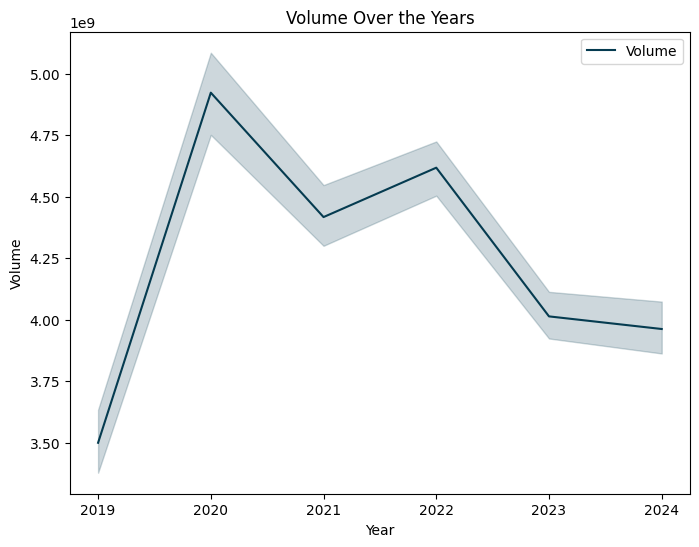

In [13]:
# Create the line plot using Seaborn
data['Year'] = data['Date'].dt.year
plt.figure(figsize=(8, 6)) # Set the figure size

# Create a line plot using Seaborn to visualize how the 'Volume' has changed over the years
sns.lineplot(data=data, x='Year', y='Volume', color='#053B50', label='Volume')

plt.title('Volume Over the Years')  # Set the title of the plot
plt.xlabel('Year') # Label for the x-axis
plt.ylabel('Volume') # Label for the y-axis

Text(0, 0.5, 'Price Difference')

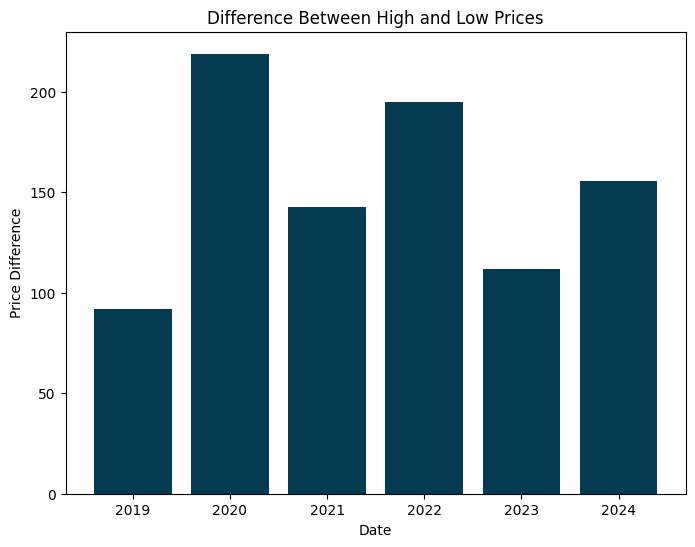

In [14]:
# Calculate the difference between 'High' and 'Low' prices
data['High_Low_Difference'] = data['High'] - data['Low']

# Create a bar plot to visualize the difference
plt.figure(figsize=(8, 6))  # Set the figure size
plt.bar(data['Year'], data['High_Low_Difference'], color='#053B50')
plt.title('Difference Between High and Low Prices')  # Set the title of the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Price Difference')  # Label for the y-axis

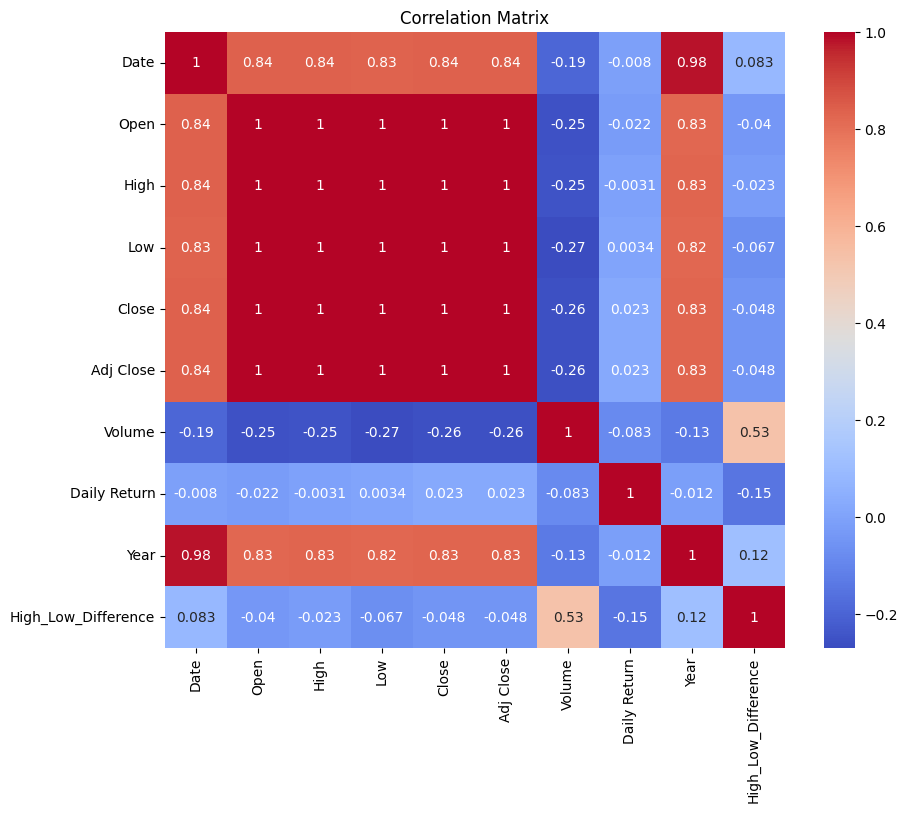

In [15]:
corr_matrix =data.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,annot=True,cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Text(0, 0.5, 'Adj Close Price')

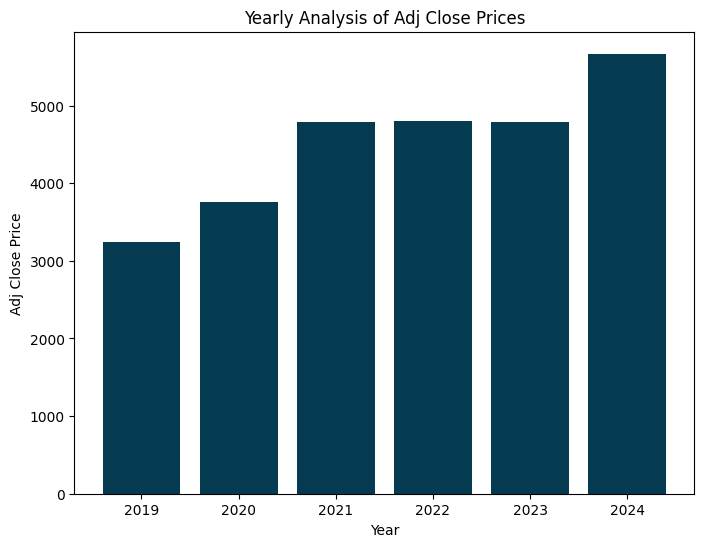

In [16]:
# Create a bar plot to visualize the relationship between 'Year' and 'Adj Close' prices
plt.figure(figsize=(8, 6))
plt.bar(data['Year'], data['Adj Close'], color='#053B50')
plt.title('Yearly Analysis of Adj Close Prices')
plt.xlabel('Year')
plt.ylabel('Adj Close Price')

In [17]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Daily Return', 'Year', 'High_Low_Difference'],
      dtype='object')

In [18]:
#droping temp columns
data.drop(columns=['Daily Return', 'Year', 'High_Low_Difference'], axis=1, inplace=True)

### Model Building

##### We will build RNN models with the first 80% of the data and forecast the last 20%. We have make sure to put test data in the last portion of overall data.

#### Prep Data

In [19]:
close_data = data[["Close"]]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 50
X, y = create_sequences(scaled_data, sequence_length)

In [39]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

#### Model 1: LSTM (RNN) Model

In [40]:
model = Sequential()
model.add(LSTM(50, activation = "relu", input_shape=(sequence_length, 1)))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,701 (45.71 KB)

 Trainable params: 11,701 (45.71 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
history = model.fit(X_train, y_train, epochs=20, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0495 - val_loss: 7.1147e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 6.3655e-04 - val_loss: 8.4546e-04
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.3064e-04 - val_loss: 3.8671e-04
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.3157e-04 - val_loss: 8.7470e-04
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.9989e-04 - val_loss: 3.4521e-04
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.7561e-04 - val_loss: 4.1317e-04
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6646e-04 - val_loss: 3.1755e-04
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2498e-04 - val_loss: 2.3484e-04
Epoch 9/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.4715e-04 - val_loss: 3.1747e-04
Epoch 10/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3907e-04 - val_loss: 4.2302e-04
Epoch 11/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.0563e-04 - val_loss: 

In [42]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.7235e-04
Test Loss: 0.0002807149139698595


In [43]:
# Make predictions
y_pred = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


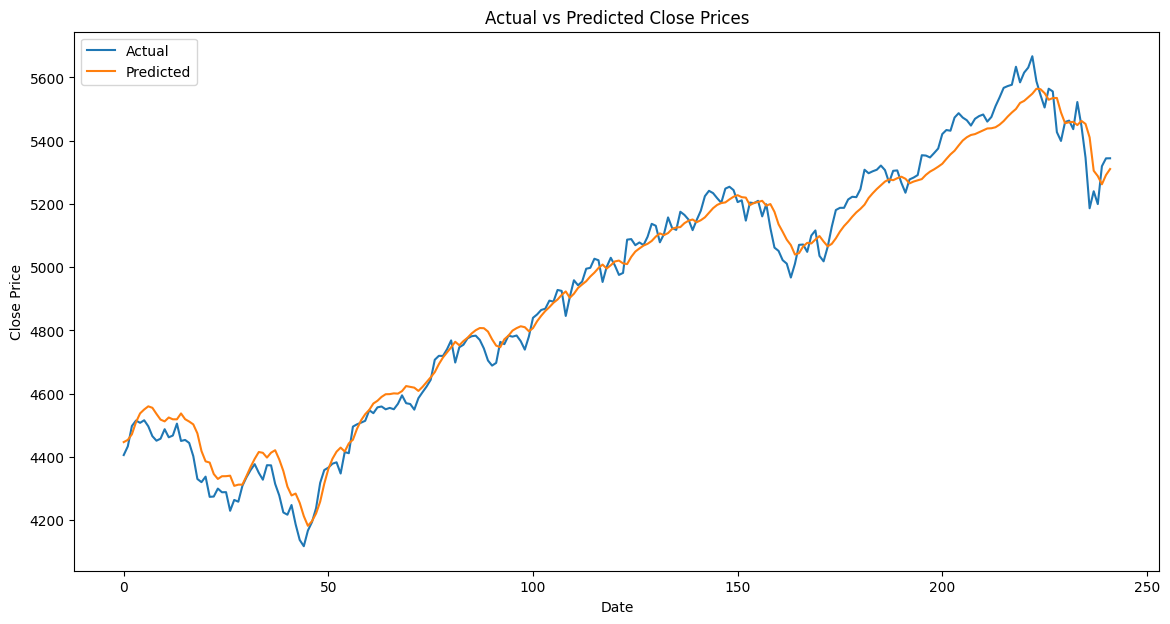

In [44]:
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

plt.figure(figsize=(14,7))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### Model 2: LSTM (RNN) Model

In [49]:
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [50]:
model2 = Sequential()
model2.add(LSTM(50, activation="relu", return_sequences=True, input_shape=(sequence_length, 1)))
model2.add(LSTM(50, activation="relu"))
model2.add(Dense(100))
model2.add(Dense(25))
model2.add(Dense(1))
opt1=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
model2.compile(optimizer=opt1, loss='mse')
model2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 50, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 100)                 │           5,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 25)                  │           2,525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,251 (149.42 KB)

 Trainable params: 38,251 (149.42 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
history2 = model2.fit(X_train, y_train, epochs=20, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.0417 - val_loss: 0.0028
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.7544e-04 - val_loss: 0.0014
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.1023e-04 - val_loss: 0.0021
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.3698e-04 - val_loss: 5.6460e-04
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.8984e-04 - val_loss: 0.0022
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.1796e-04 - val_loss: 9.5795e-04
Epoch 9/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.1927e-04 - val_loss: 3.9493e-04
Epoch 10/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.2122e-04 - val_loss: 4.0494e-04
Epoch 11/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9364e-04 - val_loss: 3.4473e-04
Epoch 12/20

In [55]:
loss2 = model2.evaluate(X_test, y_test)
print(f'Test Loss: {loss2}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010
Test Loss: 0.0011253617703914642


In [56]:
# Make predictions
y_pred = model2.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


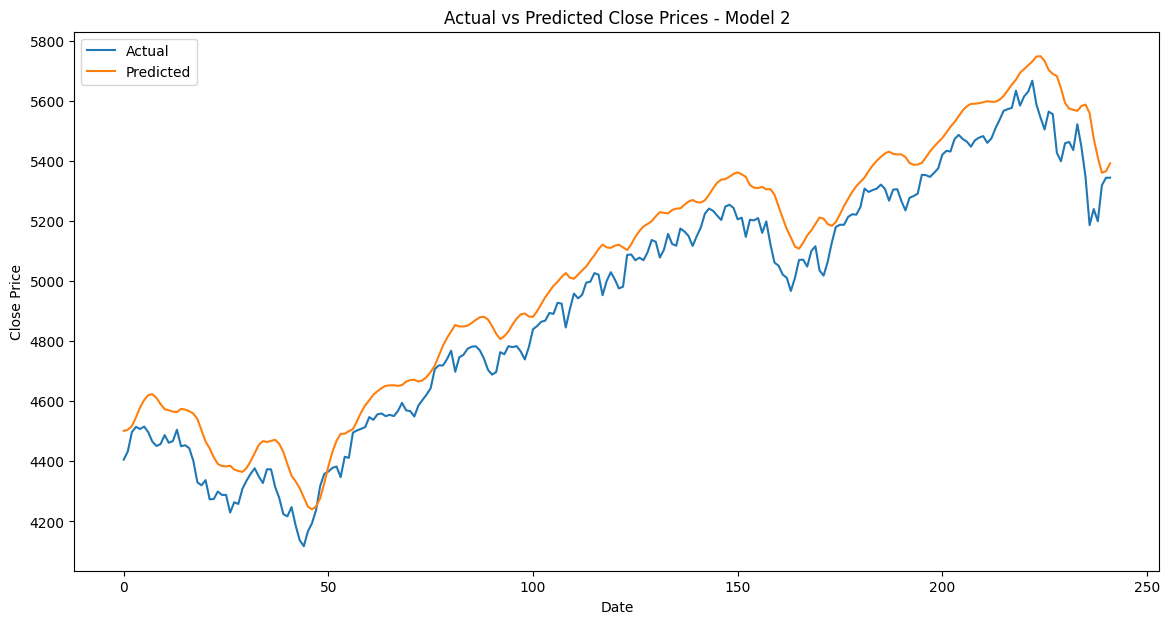

In [57]:
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

# Plotting
plt.figure(figsize=(14,7))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Close Prices - Model 2')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### Model 3: LSTM (RNN) Model

In [58]:
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [59]:
# Model 3: LSTM with Dropout
model3 = Sequential()
model3.add(LSTM(50, activation="relu", return_sequences=True, input_shape=(sequence_length, 1)))
model3.add(LSTM(50,return_sequences=False,activation='relu'))
model3.add(Dense(100))
model3.add(Dropout(0.2))
model3.add(Dense(25))
model3.add(Dense(1))
opt1=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
model3.compile(optimizer=opt1, loss='mse')
model3.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 50, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 100)                 │           5,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 25)                  │           2,525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,251 (149.42 KB)

 Trainable params: 38,251 (149.42 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
history3 = model3.fit(X_train, y_train, epochs=20, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0481 - val_loss: 0.0020
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0022 - val_loss: 9.8544e-04
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0019 - val_loss: 8.6685e-04
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - val_loss: 7.5509e-04
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - val_loss: 6.8803e-04
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - val_loss: 9.9781e-04
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0010 - val_loss: 5.6705e-04
Epoch 9/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - val_loss: 5.2072e-04
Epoch 10/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013 - val_loss: 9.6376e-04
Epoch 11/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010 - val_loss: 4.6171e-04
Epoch 12/20
97/97 ━━━━━━━━━

In [62]:
loss3 = model3.evaluate(X_test, y_test)
print(f'Test Loss: {loss3}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 4.9011e-04
Test Loss: 0.0006338502280414104


In [63]:
# Make predictions
y_pred = model3.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


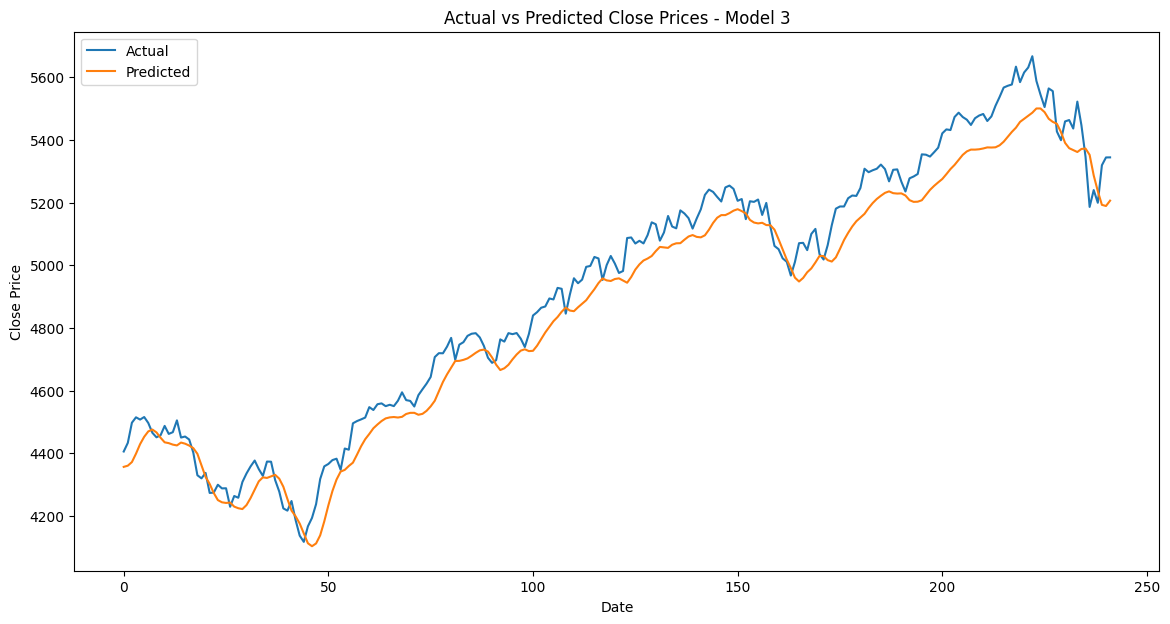

In [64]:
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

# Plotting
plt.figure(figsize=(14,7))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Close Prices - Model 3')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

The management or research question of interest is:

**How can we accurately predict the future stock prices of the S&P 500 index using historical data?**


Why is this important?

1. **Investment Decision-Making**: Accurate stock price predictions can help investors make informed decisions about buying, selling, or holding assets. This can maximize returns and minimize risks.

2. **Risk Management**: For financial institutions and individual investors, understanding potential future price movements is crucial for managing risk. It helps in setting appropriate stop-loss levels, hedging strategies, and portfolio allocations.

3. **Market Analysis**: Businesses and analysts use stock price forecasts to gauge market trends and economic health. This can influence broader business strategies, such as expansion plans or cost-cutting measures.